# Neural Network for CIFAR classification. Regularisation.

In this hometask you'll implement and train a neural network for classification of images of CIFAR dataset. In this hometask, we will also learn about two types of regularisation layers that are widely used in NNs — Dropout and BatchNorm, and you will add them to your network for CIFAR classification.

CIFAR is a dataset of RGB images containing 10 classes. Here's the list of the classes and their indices:


| Label        | Class           |
| ------------- |:-------------:|
| 0     | Airplane |
| 1    | Automobile      |
| 2 | Bird      |
| 3 | Cat      |
| 4 | Deer      |
| 5 | Dog      |
| 6 | Frog     |
| 7 | Horse     |
| 8 | Ship     |
| 9 | Truck     |



Let's also create a dictionary mapping class indices to the names. We will need it later for converting model outputs to class names.

In [ ]:
class_to_label = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

label_to_class = {name: idx for idx, name in class_to_label.items()}

Here's how images in CIFAR look like:

![alt text](https://miro.medium.com/v2/0*BdetXYemwXwOqNTs.jpg)

## Loading data

In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
from IPython.display import clear_output

We'll use `torchvision` library to load the dataset this time.

In [ ]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/vqf0qQnpb34dbA) -o cifar_10.zip
! unzip -qq cifar_10.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  162M  100  162M    0     0  13.4M      0  0:00:12  0:00:12 --:--:-- 18.8M


## Task 1. Implement dataset class for CIFAR data (10 points)

Your task is to implement Dataset class for processing CIFAR data.

Some things to think about:
- do not load all the images into memory in `__init__` method. Store only images paths, and load image based on index from disk only in `__getitem__` method
- think about how to store info about available images and their corresponding labels in `__init__` method. Remember that you need to implement `__len__` method, which should return total number of elements (i.e. number of images) in data.
- remember that you don't need to shuffle data in dataset class, this is done in dataloader (which you don't need to implement).
- Don't forget that you need to store labels as integers between 0 and 9. Use `label_to_class` dict defined above to convert names into numbers.
- When you load the images, they most likely will be represented as arrays with elements in range [0, 255], representing intencities of RGB values of pixels. You'll need to normalise the data. There are different approaches to that. As a simple idea, you might divide all the values by 255. so that they become in a range of [0, 1]. You can try other ideas for normalising as part of this assignment.

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, images_paths):
        '''
        method for dataset initialisation
        images_paths — path to the folder with data
        '''
        self.images = []
        self.labels = []

        for label_name in os.listdir(images_paths):
            label_path = os.path.join(images_paths, label_name)
            if os.path.isdir(label_path):
                label_idx = label_to_class[label_name]
                for img_name in os.listdir(label_path):
                    self.images.append(os.path.join(label_path, img_name))
                    self.labels.append(label_idx)

    def __len__(self):
        '''
        method returning length of the data
        '''
        return len(self.images)

    def __getitem__(self, idx):
        '''
        method that given an index idx returns an element
        corresponding to that index from the dataset
        '''
        image = Image.open(self.images[idx]).convert("RGB")
        image = torch.FloatTensor(np.array(image)) / 255.0
        label = self.labels[idx]
        return (torch.FloatTensor(image), label)

In [ ]:
train_data = CustomDataset('./cifar10/train')
test_data = CustomDataset('./cifar10/test')

Let's also split training data into train and **validation** parts, so we can check metrics on validation part between training epochs

**Couple of words about validation data:**
In the practical session, we only used training and testing datasets. We trained neural network for some epochs on training data, and then tested trained model on testing data. However, the process of training of neural network (gradient descent) is iterative, and we would like to be able to catch the moment during training when our network is trained optimally, not already underfitted and not yet overfitted.

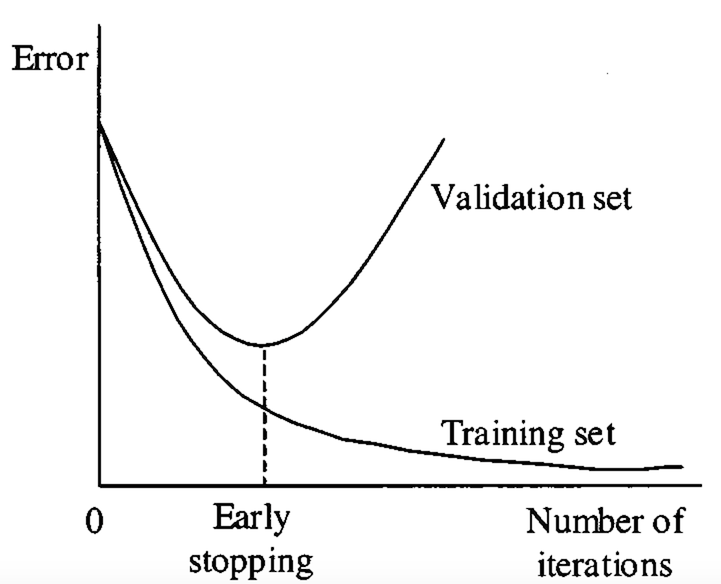


So the logical way to do that is to check loss/accuracy (or any other metric we are interested in) of your network after each epoch on some held-out data different from training data. We could use testing data for that, but then there's a risk of overfitting for the test data. The thing is, if we use testing data for deciding when to stop training, we are actually choosing the model that behaves best on the testing data. So testing data is actually affecting our choice of the best model, so we can't use this same data for final testing anymore, as we always need to test the model on data that was not involved in training or hyperparameters choice anyhow. That is why we need to have distinct validation dataset, which is used to estimate the performance of the model after each epoch and choose the best model. And after obtaining the final model, we will test it on the testing data.

So the logic here is similar to the logic of having validation dataset in classical machine learning, which you've discussed previously. Validation data is used to pick the hyperparmeters, and testing data should only be used purerly for testing the final model.

In practice, in training of neural networks this is most often done as follows: neural network is trained on large number of epochs, and after each epoch its weights are saved, and loss on validation data is calculated and saved as well. After training is done, the best epoch is determined as that having best validation loss, and weights corresponding to that epoch are loaded into the model. This is considered as final model.

Sometimes, hovewer, it is effifient to stop training if for some consecutive epochs validation loss is not going down. In this case we assume that the overfitting has begun and validation loss will not improve anymore again.  This is called **early stopping**.

So let's split our training data into training and validation parts:

In [ ]:
# we will allocate 80% of all images to the training sample
train_size = int(len(train_data) * 0.8)
# the remaining 20% will go to validation
val_size = len(train_data) - train_size

# splitting the data
torch.manual_seed(42)
train_data, val_data = torch.utils.data.random_split(train_data, [train_size, val_size])

Now let's take a look at a few pictures to understand what we are dealing with.

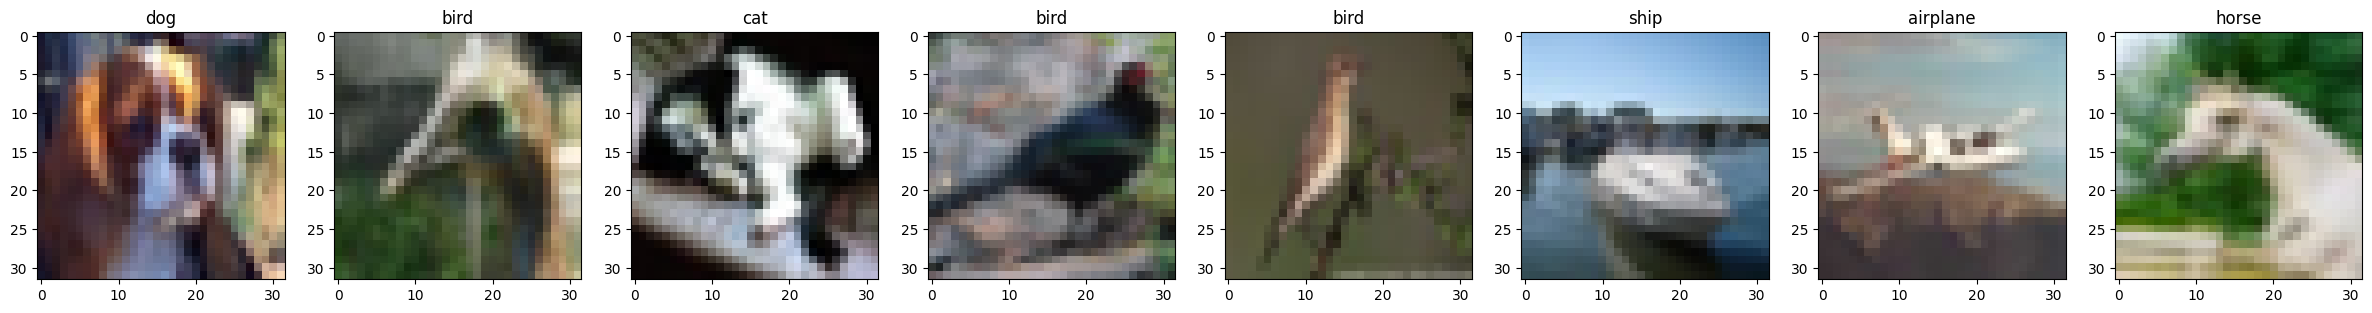

In [ ]:
# create a plot with 8 subplots to visualise 8 images
f, axes= plt.subplots(1, 8, figsize=(30,5))

for i, axis in enumerate(axes):
    img, label = train_data[i]
    axes[i].imshow(img)
    axes[i].set_title(class_to_label[label])
plt.show()

Let's see what size the pictures are:

In [ ]:
img, label = train_data[0]
img.shape

torch.Size([32, 32, 3])

Here, 3 is the number of color channels (since the image is colored, RGB) and 32 and 32 are the width and height of the image.

Finally, let's define dataloaders for training, validation and testing parts. You can choose your favourite `batch_size` and experiment with that in next tasks.

In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Task 2. CIFAR classification with a fully-connected network.

Your second task is to build and train a fully-connected network for CIFAR classification. After you play with it and see how good accuracy we can get, in the third task we will talk about additional regularisation layers that we can add to our network to make it more efficient.

CIFAR dataset defines the task of multi-class classification into 10 classes. Below there is some theory on how we design neural networks for multi-class classification. If you're already familiar with that, you can skip it and move to the task 2.1

### Neural Network for multi-class classification

We already know how to build a neural network for the tasks of binary classification and regression. Let's learn what to do if we have a task of multi-class classification.

Consider a dataset for classification of crocodiles into 3 types:

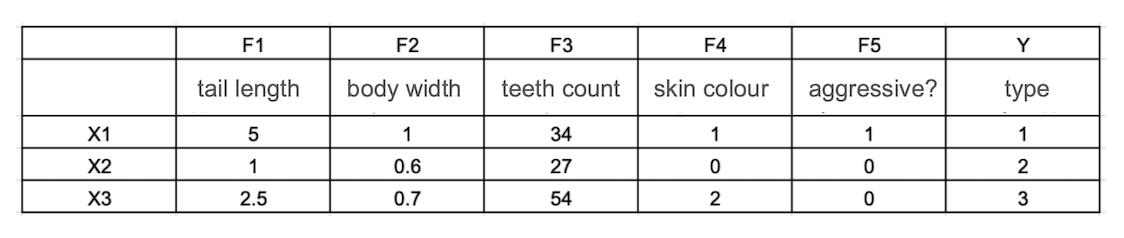

The simplest idea of neural network architecture for this task would be having one output neuron, which would output the class number of input object.

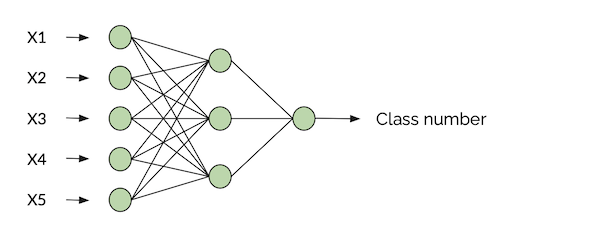

But there's a problem: how do we interpret outputs of such network? Let's say for some object our network outputs the value of 2.12. Does it mean that most likely our object belongs to the class 2? Or does the network think that the object is somewhere in between classes 1 and 3?

Okay, this was not the greatest idea. Let's now note, that a task of milti-class classification to $n$ classes can be wieved as $n$ binary classification tasks:
- does element belong to class 1?
- does element belong to class 2?
- ...
- does element belong to class n?

We can then make our neural network have n output neurons with Sigmoid activation function, and each output neuron will solve a corresponding binary classification tasks. So in our case with crocodile data it will look like that:


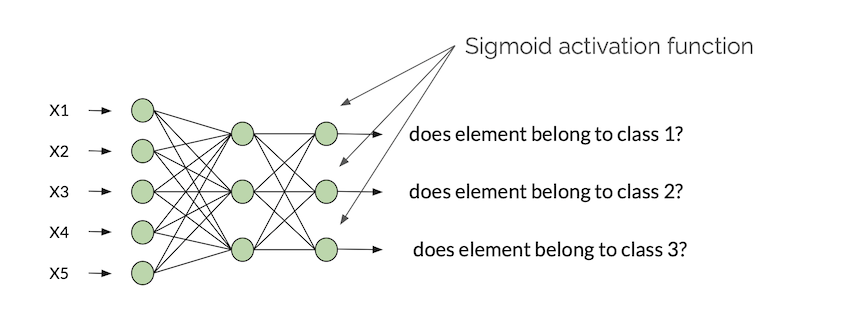

Such a network structure is suitable for the task of multi-label classification, where each input object can belong to arbitrary number of classes, i.e. where events "input object X belongs to class i" are independent. In the case of multi-class classification, these events are not independent, as each object can only belong to one class. So we would like decisions of neuron of the last layer to be agreed in some way.

The idea that comes to mind is the following: we would like neurons of the last layer to output a probability distribution over the classes. This means that the output of $i^{th}$ neuron will represent a probability that the input object belongs to the class $i$.

We also know the true distribution for each object, which is represented as one-hot vector. So as a loss function we could use some similarity measure between the true and predicted distributions.

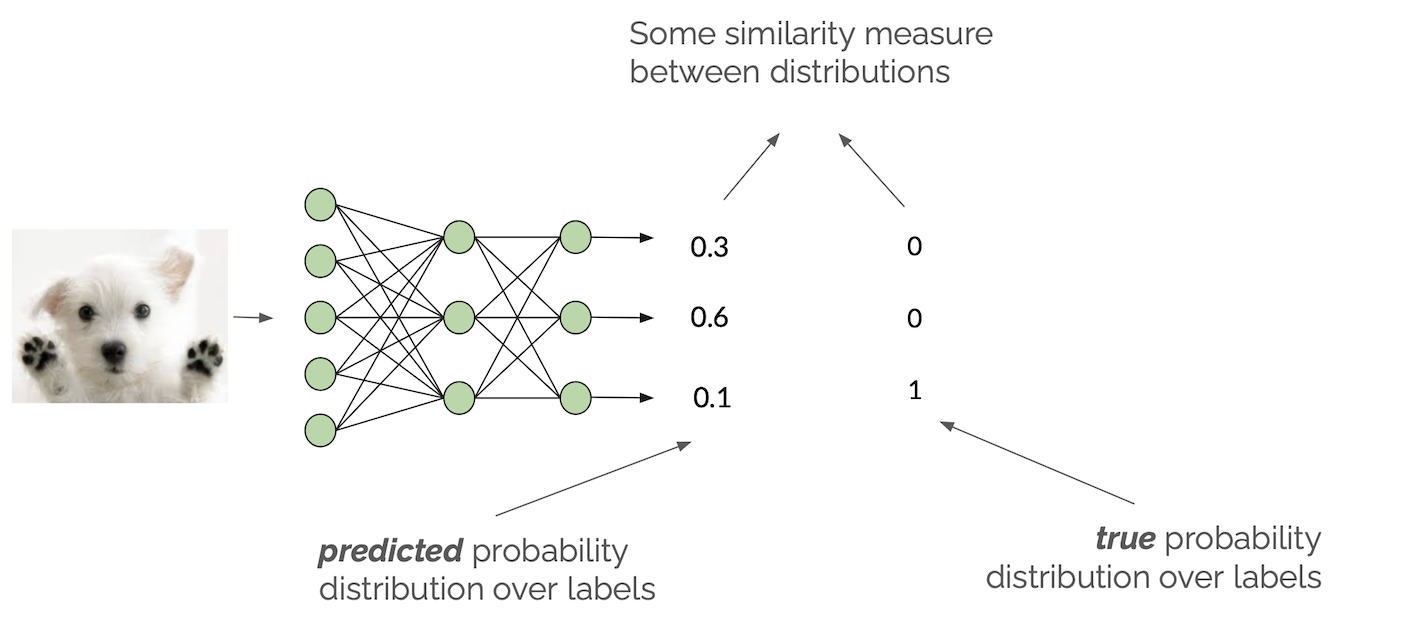

So we need to somehow convert the logits (outputs of the last linear layer) into the probability distribution. Let's do it using SoftMax activation function:

$$(p_1, p_2, p_3) = SoftMax(\widehat{p_1}, \widehat{p_2}, \widehat{p_3}) = \left( \frac{e^{\widehat{p_1}}}{\sum e^{\widehat{p_i}}}, \frac{e^{\widehat{p_2}}}{\sum e^{\widehat{p_i}}}, \frac{e^{\widehat{p_3}}}{\sum e^{\widehat{p_i}}} \right)$$

We can see that SoftMax does indeed convert logits into probability distribution, as the sum of all elements becomes 1, and value of each element is in $[0, 1]$.

And as a similarity measure between the output distribution and true distribution we will use [cross-entropy](https://en.wikipedia.org/wiki/Cross-entropy), which is a measure of similarity of two probability distrubutions from information theory.

$$CE(y, p) = - \sum y_i log(p_i)$$

LogLoss is a binary version of cross-entropy.





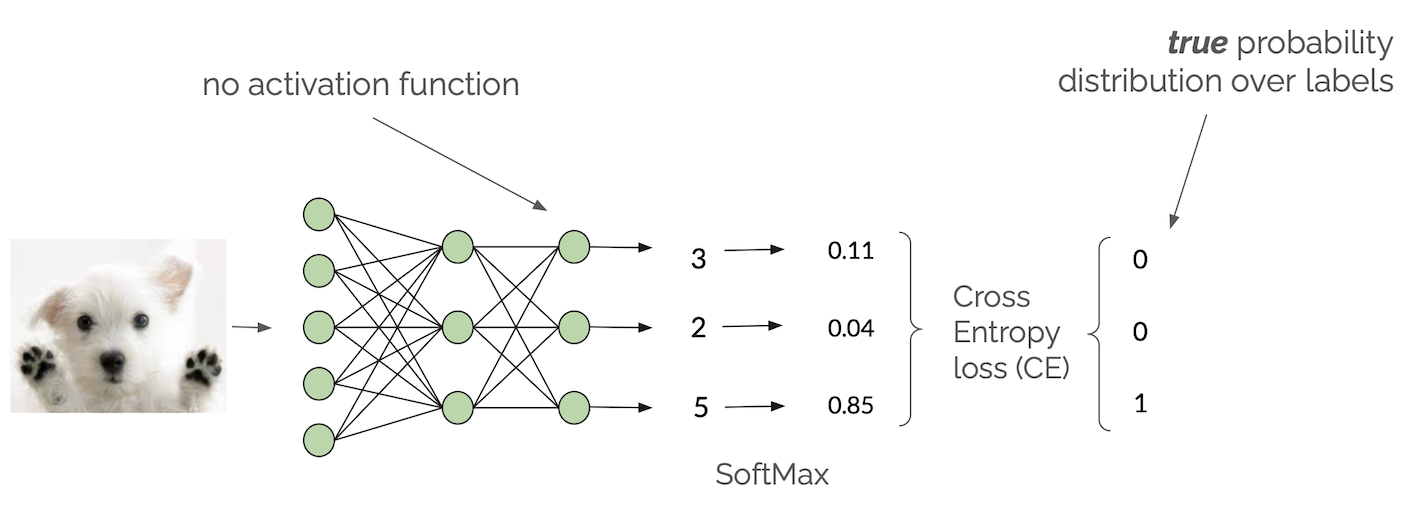

Let's also say a couple of words about why using SoftMax, as there are many ways to convert logits into probability distribution.

First, here's log function inside the formula of cross-entropy. If we pass logits $\widehat{p_i}$ through exponential function before feeding them into cross-entropy, we will end up $log(p_i)$ having the same magnitude as $\widehat{p_i}$. So this will encourage a neural network to output logits which have the same magnitude as $y_i$.

Second, SoftMax is a short for "Soft Maximum", and it has this name because it rebalances the values so that the maximum value becomes more pronounced, close to 1, while all other values get closer to zero.

Here's an example of how SoftMax changes logits:

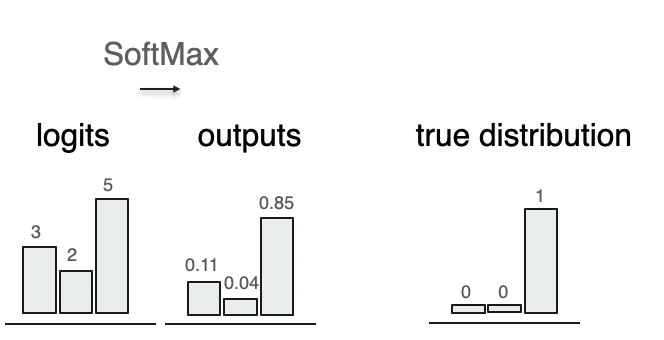

So it is called "Soft Maximum", as it acts almost like argmaximum function, but softer, not putting all the probability weight into one place.

To sum up, if you are building neural network for $n$-class classification task with $n>2$, then:
- last layer of the network should have $n$ neurons
- activation of the last layer of the network should be SoftMax (https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
- loss function is cross-entropy (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Note, however, that PyTorch implementation of CE (torch.nn.CrossEntropyLoss) expects to have logits as input, not probabilities after SoftMax. It applies SoftMax inside loss function. This is done due to efficiency of computing gradients. So if you use torch.nn.CrossEntropyLoss as loss function, there should be no activation function in the last layer of the network.

### Task 2.1 Write a neural network for CIFAR images classification (5 points)

Here your task is to write any architecture that would process CIFAR image. Think about the following:
- How many input and output neurons you network should have?
- What activation function should the last layer have? We are going to use [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) as our loss function. What does it get as input according to the documentation?

Note that shape of CIFAR images coming from dataloaders is (3, 32, 32), and we need to flatten images into single vectors. There is a special layer in torch.nn module for this, called [Flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html). If we use it as the first layer in our model, it will automatically flatten images into vectors.

In [ ]:
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()

        # define layers and activation function that your model will have
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):

        x = self.flatten(x)


        # define a flow of input through your layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)


        return x

And create a network:

In [ ]:
net = Net()

### Task 2.2. Define a train function. (5 points)

You can borrow the code from practice session. Hovewer, we'll make one addition to the training code: you will need to add evaluation on validation data after each epoch.

Hints:
- Don't forget about the GPU usage! For CIFAR data it becomes important.
- it might also be beneficial to see how training loss evolves during training, this will help you do experiments later. You can either save average of losses on batches per epoch into array and return it as output of the `train` function, so you can then visualize it using [matplotlib.plot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html). Or you can add plotting average of losses on batches per epoch inside the `train` function. In this case you might also need using a function to clear output of the cell, so you can draw new plot after each epoch. You can find how to do it [here](https://stackoverflow.com/questions/24816237/ipython-notebook-clear-cell-output-in-code)
- Consider saving model weights after each epoch. You can either save weights to different files after each epoch, or save weights each time when validation loss gets smaller than ever before. Don't forget to load best weights after the end of the training.

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from IPython.display import clear_output

def train(model, train_loader, val_loader, criterion, optimizer, num_epoch):
    model.to(device)
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}
    best_model = None

    for epoch in tqdm(range(num_epoch)):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()

        clear_output(wait=True)
        plt.plot(history["train_loss"], label="Train Loss")
        plt.plot(history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss")
        plt.show()

    model.load_state_dict(best_model)
    return model, history


And let's define loss function, optimizer, dataloader and train our network.

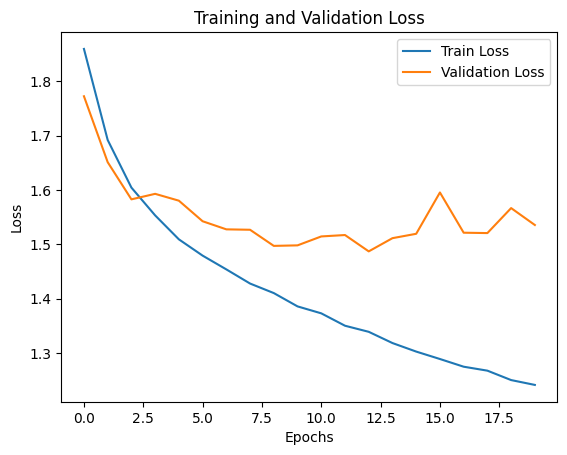

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

### Task 2.3. Write a code for model evaluation (5 points)

After we train our neural network, we'll need to evaluate it on test data and compute accuracy metric. Let's now define the function for it. Your task is to fill the gaps in the code below.

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate(model, loader, criterion):
    '''
    args:
        model - our neural network model
        loader — structure which yields batches of test data
        criterion - loss function from `torch.nn` module
        device - the device where the model and data should be placed (e.g., 'cuda' or 'cpu')
    '''

    losses = []
    y_pred_list = []
    y_true_list = []

    model.eval()

    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        with torch.no_grad():
            y_pred = model(X_batch)

            loss = criterion(y_pred, y_batch)
            losses.append(loss.item())

        _, y_pred_class = torch.max(y_pred, dim=1)

        y_pred_list.extend(y_pred_class.cpu().numpy())  # move to CPU if using CUDA
        y_true_list.extend(y_batch.cpu().numpy())

    accuracy = accuracy_score(y_true_list, y_pred_list)

    return np.mean(losses), accuracy

And let's evaluate our trained network on test data.

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.5055239411969534, 0.4783)

### Task 2.4. Train the best neural network to classify CIFAR data (20 points)

Now you have a network that can be trained and evaluated on binary classification data. Your next task is to make it better, so that your neural network can achieve as high accuracy as possible on the test part.

You are free to build any neural network architecture you want and use any hyperparameters for training. Here are some tips:
- Start with no more than 2-3 hidden layers each having 5-7 neurons
- Think about how many neurons your input and output layers should have
- What activation function do you need to use in the last layer?
- Play with number of layers, numbers of neurons in layers, different activation functions
- Try different training **hyperparameters**: learning rate, number of epochs, type of optimizer, batch size
- Try different kinds of image preprocessing inside you Dataset class, e.g. resizing/normalising images, etc.

After you've done experimenting, describe your findings. Try to answer the following questions:
- What is maximum accuracy on test test that you were able to achieve? Do you think it is possible to get higher accuracy using fully-connected network? Why?
- Have you observed overfitting? When does it start, i.e. how big the network should be?
- How does the behaviour of the model change when you change different hyperparameters?
- What interesting behaviour have you observed? What was beneficial and what did not influence the model?

Here is also a hint on experimenting: try to change one parameter at time. When you change the parameter, retrain the network and see how the behaviour has changes. Log the results, so you can then a general picture of how each parameter influences the model training. This will also help you not to forget what you have already tried.





In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(3 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc_out = nn.Linear(32, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc_out(x)
        return x

In [ ]:
net = Net()

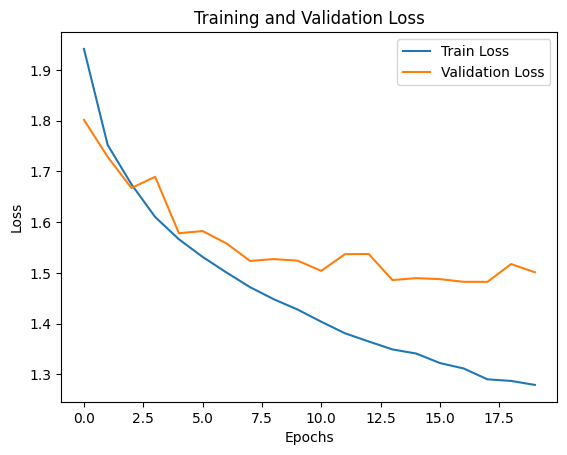

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.4620610675491845, 0.4914)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # flatten layer
        self.flatten = nn.Flatten()

        # define layers and activation function that your model will have
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):

        x = self.flatten(x)


        # define a flow of input through your layers
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)


        return x


net = Net()

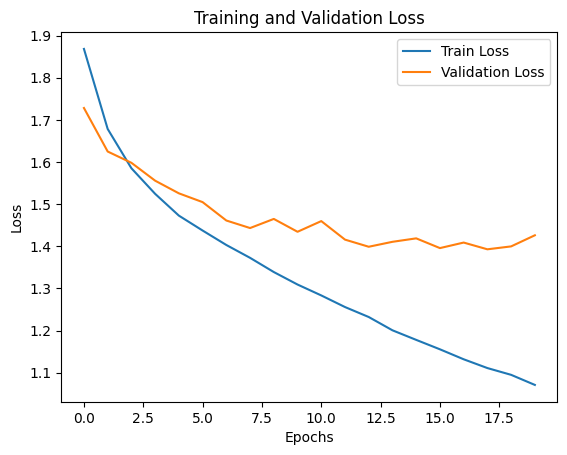

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.4018431936209195, 0.5159)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 10)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        self.selu = nn.SELU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.selu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.tanh(self.fc5(x))
        x = self.leaky_relu(self.fc6(x))
        x = self.selu(self.fc7(x))
        x = self.fc8(x)

        return x

In [ ]:
net = Net()

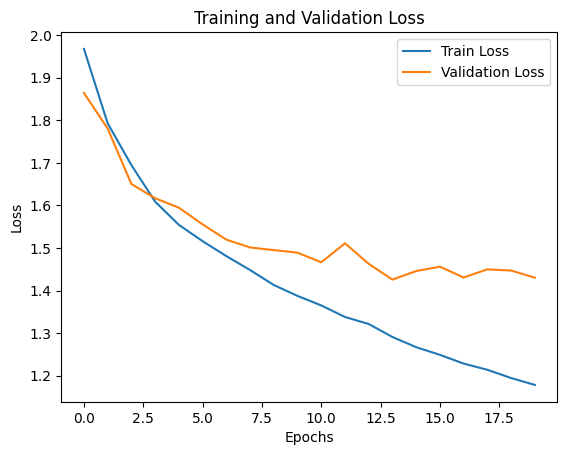

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.3982176642638806, 0.5188)

### All conclusions

1) What is the maximum accuracy on the test set that you were able to achieve? Is it possible to get a higher accuracy using a fully connected network? Why?
The highest achieved accuracy was 51.88%. In theory, higher accuracy might be possible, but fully connected networks have limitations. They are not well-suited for capturing spatial dependencies in images, making them less effective compared to convolutional neural networks (CNNs).

2) Did you observe overfitting? When does it start, i.e., how big should the network be?
Yes, overfitting started at epoch 8-10. After this point, training accuracy continued to improve, but test accuracy either stagnated or declined. This indicates that the model begins memorizing the training data instead of generalizing.

3) How does the model's behavior change when you adjust different hyperparameters?

Increasing the number of layers and neurons (Model 4) gave a small accuracy improvement but not a drastic one.
Different activation functions affect convergence speed and training efficiency. For example, SELU and LeakyReLU help with vanishing gradients.
Larger models generally require more epochs to reach their full potential, but after epoch 8-10, overfitting can start.

4) What interesting behavior did you observe? What was beneficial, and what did not influence the model?

Using different activation functions didn’t result in a sudden jump in accuracy, but it may have contributed to training stability.
Smaller architectures (Models 1 and 2) performed worse than deeper ones, confirming that more complex tasks need more parameters.
Adding more layers improved performance but not drastically, suggesting that fully connected networks might have a ceiling on their effectiveness for this problem.

## Task 3. Adding regularisation layers

In this section we will get familiar with two powerful techniques for regularizing neural networks — Dropout and BatchNorm. First we'll review the theory, and then you will add them to your network for CIFAR classification.

Note that these techniques (or their modifications) are still used in modern neural networks such as LLMs. We will see it further in the course

### BatchNorm

Let's look at a neural network that has several layers. Note that a subnetwork starting from the $i^{th}$ layer can be seen as a sub-model, which takes outputs of the previous layer as input. We already know that it is important to normalise the input data that we feed into a model. So should we also normalise inputs to hidden layers?

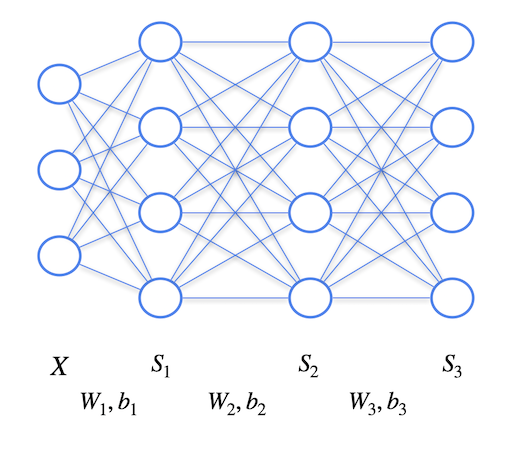

It seems thatwould  normalizing the outputs of each intermediate layer also contribute to more efficient training of the network. And **BatchNorm is the layer that performs such normalization**.

**How does it do that?** The first idea that comes to mind is to do the same thing as with input normalization: let's normalise the output of each neuron so that it has a mean=0 and std=1 across the training data.

But this idea has two issues:
1. In order to shift outputs of each neuron so that thay have fixed mean and std across all the training data, we would first need to calculate each neuron's outputs on all the objects from the training data. This is computationally infeasible.
2. Instead of fixing mean and std of outputs, why not let neural network during training decide itself how it is better to normalise outputs of each layer?  

How to address these two issues? Here are couple of ideas:
1. We may approximate statistics (mean and std) of neuron outputs based on mini-batch data, not based on all the training data.
2. We can introduce trainable parameters that will adjust mean and std of layers' neurons.

BatchNorm is a technique of layer output normalisation that uses these two ideas. **BatchNorm is a trainable layer that normalizes the outputs of the network using trainable parameters**.

So here is what BatchNorm does:

Suppose we have a layer. On a mini-batch training iteration the layer has $b$ outputs $\{x_i\}_{i=1}^b$.

1. Calculate mean $\mu_B$ and std $\sigma_B$ of the layer outputs on a current batch:
$$\mu_B = \frac{\sum_{i=1}^b x_i}{b}$$
$$\sigma^2_B = \frac{\sum_{i=1}^b (x_i - \mu_B)^2}{b}$$
2. Normalise layer outputs using $\mu_B$ and $\sigma_B$:
$$\widehat{x}_i = \frac{x_i - \mu_B}{\sigma_B+ \epsilon}$$
3. Calculate modified layer outputs as follows:
$$y_i = \gamma \widehat{x}_i + \beta$$

Here $\gamma$ and $\beta$ are trainable parameters.

So here happens the following:

* First, on steps 1-2, layer outputs are normalized so that each neuron has mean value of 0 and standard deviation of 1 across elements of the batch.
* Then, on step 3, means and standard deviations of each neuron are shifted by $\beta$ and $\gamma$ respectively. Both $\beta$ and $\gamma$ are trainable parameters, which means that during training the neural network is allowed to adjust mean and standard deviation of layer's outputs. $\beta$ and $\gamma$ are trained together with all the model parameters during gradient descent.



    


So we have described what BatchNorm does during training. **Now let's think about inference.** Here we have one problem: during inference, we want to be able to get the output of a model for a single object, i.e. we can have batch size equal to 1. On step 1 of our BatchNorm algorithm, we calculated mean and std estimates across current batch of data, and if we have only one element in the batch, we can't get reliable mean and std estimates for neurons' outputs.

So what shall we do? The idea is the following: let's gather the statistics of mean and std values calculated for mini-batches during training. And then we will use this statistics during inference. Actually, this aligns with how we normalise input data: during inference we use statistics calculated on the training data to normalise the test data.

So we will need to add one step to the BatchNorm algorithm during training:

Before training, define veriables
$$\mu_r= 0$$
$$\sigma_r = 0$$
We also fix a number $momentum\in[0,1]$. We'll see what it does in a second.

Now, for every batch:
1. Calculate mean $\mu_B$ and std $\sigma_B$ of the layer outputs on the current batch:
$$\mu_B = \frac{\sum_{i=1}^b x_i}{b}$$
$$\sigma^2_B = \frac{\sum_{i=1}^b (x_i - \mu_B)^2}{b}$$
2. Update $\mu_r$ and $\sigma_r$:
$$\mu_r = (1 - momentum)\cdot\mu_r + momentum \cdot \mu_B$$
$$\sigma_r = (1 - momentum)\cdot\sigma_r + momentum \cdot \sigma_B$$
(These are *exponential moving averages*.)
3. Normalise layer outputs using $\mu_B$ and $\sigma_B$:
$$\widehat{x}_i = \frac{x_i - \mu_B}{\sigma_B+ \epsilon}$$
4. Calculate modified layer outputs as follows:
$$y_i = \gamma \widehat{x}_i + \beta$$


And during inference, BatchNorm layer will perform the following. Suppose we have a layer output $x_i$.
1. Normalise outputs of the layer using $\mu_r$ and $\sigma_r$:
$$\widehat{x}_i = \frac{x_i - \mu_r}{\sigma_r + \epsilon}$$
2. Calculate modified layer outputs as follows:
$$y_i = \gamma \widehat{x}_i + \beta$$




So this is the whole thing about BatchNorm. BatchNorm really does stabilise and accelerate training. Here is a figure from original paper on BatchNorm, showing performance of the same neural network without BatchNorm and with BatchNorm added in different ways. We see that versions of the model with BatchNorm are able to achieve the same accuracy as model without BatchNorm after much smaller amount of training steps.

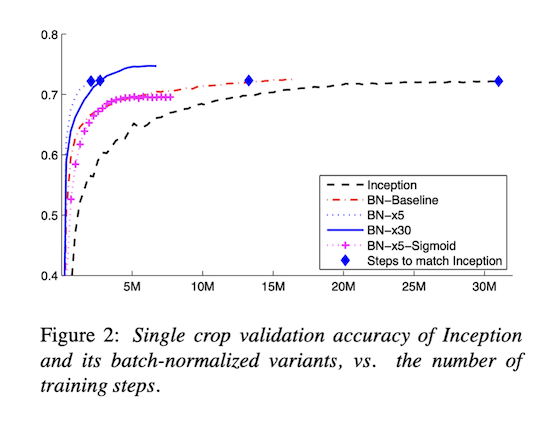

One more thing on BatchNorm before you will add it to your neural network for CIFAR classification: BatchNorm is also believed to help with the **internal covariate shift** in neural networks.

What is internal covariate shift: Each layer of the network during training must adjust to the values that the previous layer produces. During network training, the distributions of values ​​that each layer of the network produces change. And each hidden layer at each iteration of the algorithm has to adjust to the new distribution of the outputs of the previous layer. This makes training process less effective, it slows down the convergence.

BatchNorm should help with this problem, as it stabilises the distributions of layers outputs. However, the fact that BatchNorm has something to do with internal covariate shift is not proved.

Note, however, that **you will not need to do these computations during training or inference when building neural network with PyTorch**. All this behaviour is implemented inside BatchNorm layer. You need just to add it to your neural network!

### Task 3.1 Add BatchNorm to your network (10 points)

**Now to the practical part:**

BatchNorm layer in PyTorch is defined as [torch.nn.BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html). Your task is to add this layer after one or more hidden layers in your network for CIFAR classification. Experiment with where to add BatchNorm. Maybe you'll need to modify an architecture of you network to achieve better results, but start with the architecture you've built in the Task 2.

Try to answer the following questions:
- How does the performance of your network change when adding BatchNorm? Is it able to achieve better accuracy on validation/test data than without BatchNorm?
- Is your network able to achieve same accuracy in smaller amount of training iterations?
- Are you able to build a bigger model with BatchNorm and not get overfitting?
- Does optimal network architecture with BatchNorm differ from that of without BatchNorm?

### Answers

1) How does the performance of the network change when adding BatchNorm? Does it achieve better accuracy on validation/test data?
Adding BatchNorm generally stabilizes training, helps the model converge faster, and can improve test accuracy. It reduces internal covariate shift, making learning more efficient.

2) Is the network able to achieve the same accuracy in a smaller number of training iterations?
Yes, BatchNorm speeds up training because gradients become more stable, and weights can be updated more effectively. This often allows achieving the same accuracy in fewer epochs.

3) Can you build a larger model with BatchNorm and not experience overfitting?
Yes, BatchNorm helps mitigate overfitting by normalizing activation distributions, reducing the model’s sensitivity to small variations in data. This allows building deeper models without a significant risk of overfitting.

4) Does the optimal network architecture with BatchNorm differ from that without BatchNorm?
Yes, the architecture may differ. Without BatchNorm, lower learning rates and additional regularization techniques are often required. With BatchNorm, higher learning rates and deeper networks can be used due to more stable gradients.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 10)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        self.selu = nn.SELU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.bn1(self.fc1(x)))
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.selu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.tanh(self.fc5(x))
        x = self.leaky_relu(self.fc6(x))
        x = self.selu(self.fc7(x))
        x = self.fc8(x)

        return x


In [ ]:
net = Net()

There's one more thing you need to know: as we've seen, behaviour of BatchNorm is slightly different during training and during inference. Indeed, we calculate $\mu_B$ and $\sigma_B$ based on current mini-batch suring training, and we use pre-calculated $\mu_r$ and $\sigma_r$ on inference. So we need to switch between these two regimes when training and evaluating our network.

It is done using `.train()` and `.eval()` methods as follows:

In [ ]:
# turns on the training mode for all model layers
net.train()
# turns on the inference mode for all model layers
net.eval()

Net(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=512, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=64, bias=True)
  (fc7): Linear(in_features=64, out_features=32, bias=True)
  (fc8): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (leaky_relu): LeakyReLU(negative_slope=0.3)
  (tanh): Tanh()
  (selu): SELU()
)

So we'll need to add this to our training function:

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from IPython.display import clear_output

def train(model, train_loader, val_loader, criterion, optimizer, num_epoch):
    model.to(device)
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}
    best_model = None

    for epoch in tqdm(range(num_epoch)):
        model.train()
        total_loss = 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = criterion(outputs, y)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()

        clear_output(wait=True)
        plt.plot(history["train_loss"], label="Train Loss")
        plt.plot(history["val_loss"], label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training and Validation Loss")
        plt.show()

    model.load_state_dict(best_model)
    return model, history


Also don't forget to turn on `eval` mode when testing your model! Or you can add `model.eval()` inside the evaluation function.

After that, create you network with BatchNorm, define loss function & optimiser, thain that in training data and test in on testing data.

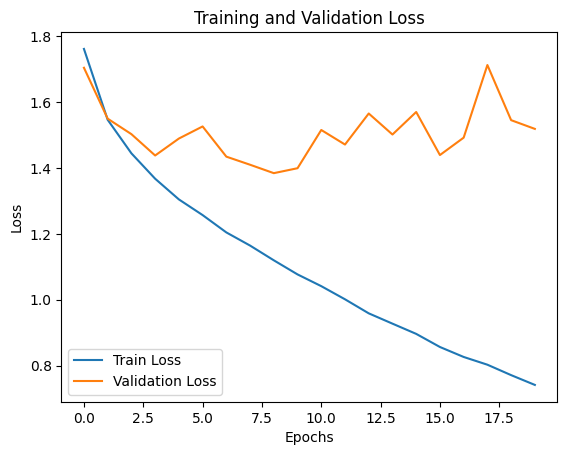

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.5097304255055923, 0.5354)

### Dropout

Dropout is another powerful technique that helps make training more efficient and reduce overfitting.

Dropout can be seen as adaptation of model ensembling technique to neural networks. Let us remind ourselves first, what model ensembling is.

Model ensembling is one of the most powerful techniques in machine learning, while being really simple. The idea is to train not one, but several models for the same task on the same training data, and then average their predictions during inference. If all of the trained models are good enough in solving the task, then averaging their predictions will lead to better performance on the task than that of each individual model. It's a little tricky what "model is good enough on the task" and "better performance on the task" mean, but here's an example: if we solve the task of binary classification, "good enough" could mean that every model in the ensemble gets accuracy > 0.5 on the test data.

Intuitively, the power of ensembling can be seen as follows: models in an ensemble make mistakes on different data samples, and averaging model predictions smoothes these mistakes, i.e. one model compensates mistakes made by another model.

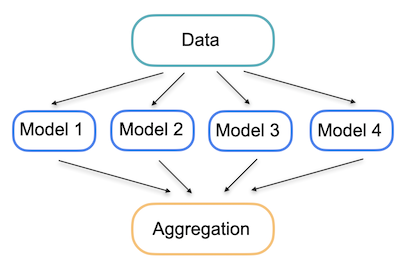

It is also important that models in an ensemble should be diverse enough. (You've already seen this when you discussed self-consistency.) That is logical: there is no point in averaging predictions of similar models, as they make the same mistakes on the same samples. To ensure diversity of models in an ensemble, [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) of training data is often used. Ideas of bootstrapping combined with emsembling leads to the well-known idea of **[Bagging](https://en.wikipedia.org/wiki/Bootstrap_aggregating)** (**B**ootstrap **Agg**regating). We will not further dive into bootstrapping or bagging here, but we encourage you to read about it.

So if ensembling is such a powerful technique, then **can we apply ensembling to neural networks as well**, can't we? Well, we can, but averaging predictions of many trained neural networks is costly. First, we would need to train many neural networks for the same task, and this would require much computational recourses and time. Second, this would slow down the inference and make it more costly as well, as we would need to get predictions from many models for each input object.

**Dropout is a technique that imitates ensembling of neural networks using only one neural network.**



The idea is the following: before training, let's choose a value of $p \in [0, 1]$. Then, during training, on each mini-batch we will "turn off" each neuron in our network with probability $p$. "Turning off" means that this neuron will not participate in forward pass og the network. Or it can be seen as neuron that is "turned off" outputting zero on a current mini-batch.

This can be visualised as follows:

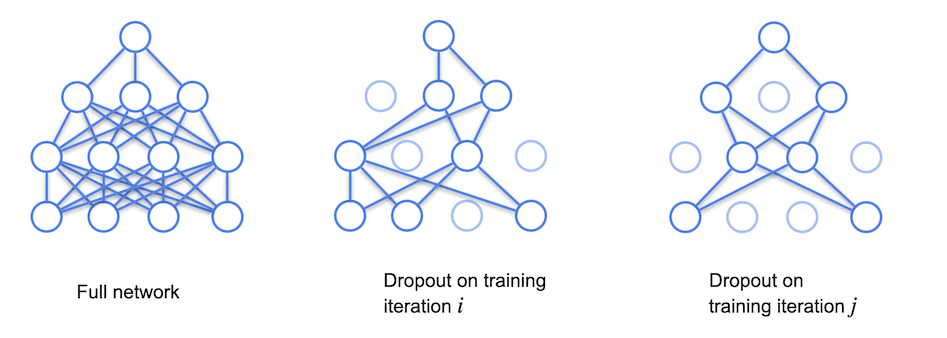

In code, "turning off" neurons in the layer can be done via simple masking. So if we apply Dropout to ф fully-connected layer, we first calculate all the neurons' outputs as usual. Then we sample a mask of zeros and ones, and each element of the mask is zero with probability $p$. After that we multiply layer output with the mask in an element-wise manner. Here is the illustration of the process:

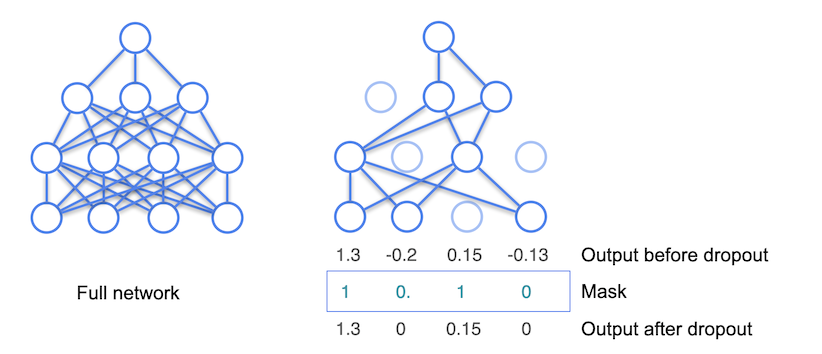

**What are the benefits of Dropout and how it is connected to ensembling:**

When using Dropout, we train a slightly different neural network (a subnetwork of the whole model) on each training iteration. This can be seen as training many different models on the same training data, outputs of which will then be aggregated on inference. However, there are differences between vanilla ensembling and Dropout:
- Each subnetwork is trained on a tiny fraction of data (mini-batch), and only for one iteration. In canonical ensembling, each models is trained on its training data until convergence
- All the subnetworks share weights, i.e. they are all parts of one whole model. In canonical ensembling all the models are completely independent
- Using Dropout, we can have exponential number of subnetworks, while in canonical ensembling there are normally 10-20 models in total

Beside this, Dropout has a nice regularisation effect on a neural network — it helps reduce overfitting. To better understand this, let's assume we've applied dropout to the layer of the network. And let's now consider one of the neurons in the subsequent layer of the network:

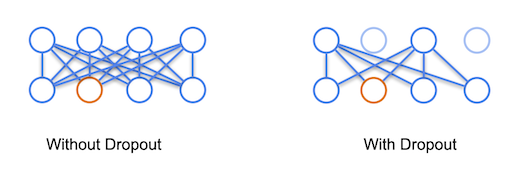

If we were not using dropout, this neron could overfit to specific information coming from the previous layer. So the previous layer has 4 neurons, and our orange neuron gets information from all of them. It might happen that during training this orange neuron learns to rely only on the information coming from only one of these 4 neurons from the previous layer; let's say the leftmost neuron. This might be expressed by the weight between the left neuron of the previous layer and our orange neuron being big, and other weights being small. This would mean that our orange neuron heavily relies on the information coming from only one neuron of the previous layer.

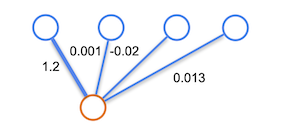

This would mean that our orange neuron has overfitted on the specific information coming from one particular neuron of the previous layer. And decision of orange neuron will be extremely bad in cases when output of this neuron of the previous layer is corrupted, or out-of-distrubution.

We can look at it from the following perspective: each neuron in the network reacts to the specific information present on the input object. If we are solving face recognition problem, a neuron might, for exmaple, extract information about some aspect of person's face, e.g. nose. It might happen that in the training data, there were only images of people's faces with noses visible, but in test data we can get an image of a person in a mask. In this case, the output of the neuron reacting to noses will be non-informative, or corrupted. And if our orange neuron relies heavily on the information coming from that neuron, it won't be able to produce meaningful output, too.

When using Dropout, we sometimes break the connection between the orange and each of the neurons in the previous layer. This makes our orange neuron produce meaningful output based on different combinatioins of features coming from previous layer. So if one of these features becomes corrupted, our neuron will still be able to generate meaningful output based on other features coming from different neurons of the previous layer.

To sum up, training with dropout makes neurons be able to perform well regardless of which other hidden units are in the model. It prevents units from forming “distinct pattern ways”, makes each unit be able to work with different input patterns. **This makes model more robust to unusual data perturbations and reduces overfitting**.


Ok, we've understood how to use Dropout during training and what benefits it provides. Now let's see **how to perform Dropout during inference**.

If we follow idea of ensembling, we should average predictions of all the models in our ensemble. But we can't do that, as we have sampled a new model on each training iteration. We could probably sample 10-20 such models (i.e. sample 10-20 versions of network with Dropout) and average their predictions on test data, but this is still costly.

Instead of doing actual ensembing, we will do the following: let's just disable Dropout during inference. But if we simply do that, this will change the expected value coming to neuron of the next layer. Imagine a neuron connected to 4 neurons of the previous layer. If we used Dropout with $p=0.5$ during training, this neuron got used to getting about half of the outputs of previous layer's neurons. If we simply disable Dropout on inference, this neuron will suddenly start getting two times more outputs, which can break its behaviour.

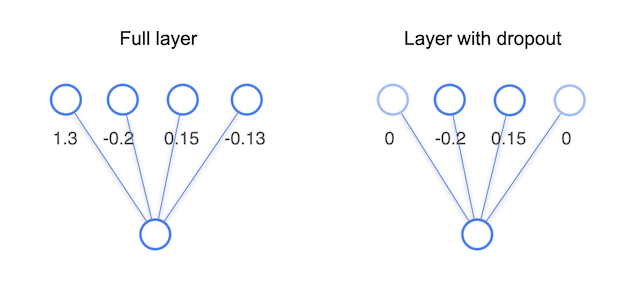

Let's compensate this. First, let's reformulate the problem: we said that the expected input value of neuron of the next layer changes if we disable Dropout. It can also be seen from another perspective: expected value of output of each neuron on the layer with Dropout changes when we disable Dropout. Indeed, each neuron's output was zeroed with probability $p$ during training, and now it is never zeroed, meaning the expected value has risen by fraction of $\frac{1}{p}$. So let's fix this. We can do it by simply multipying outputs of each neuron in the layer by $p$ during inference:

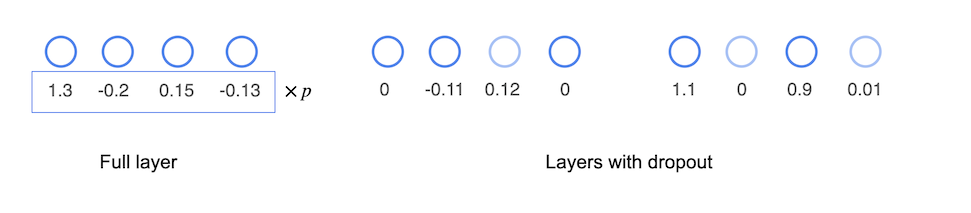

This will fix the expected value of output of each neuron during inference. In practice, however, it is more efficient to multiply outputs of neurons by $\frac{1}{p}$ during training instead. This will save time on inference, as we will not need to do another multiplication.

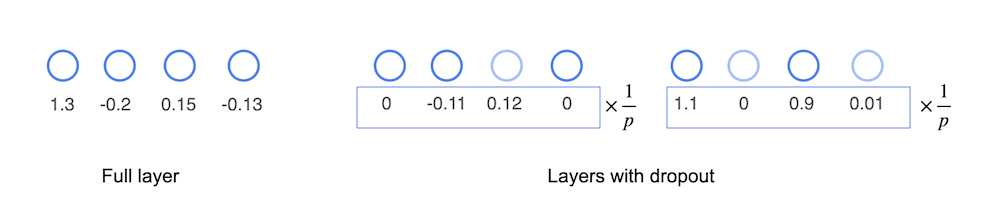

Note, however, that **you will not need to multiply anything during training or inference when building neural network with PyTorch**. All this behaviour is implemented inside Dropout layer. You need just to add it to your neural network!

So that's it! Now let's switch to practice, and add Dropout to our neural network!

### Task 3.2 Add Dropout to your network (10 points)

**Now to the practical part:**

BatchNorm layer in PyTorch is defined as [torch.nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html). Your task is to add this layer after one ore more hidden layers in your network for CIFAR classification. Experiment with where to add Dropout and what $p$ to choose. Maybe you'll need to modify an architecture of you network to achieve better results, but start with the architecture you've built in the Tasks 2 and 3.1. Try to use Dropout without BatchNorm, and then try to use Dropout with BatchNorm.

Try to answer the following questions:
- How does the performance of your network change when adding Dropout? Is it able to achieve better accuracy on validation/test data than without Dropout?
- Is it beneficial to use both Dropout and BatchNorm?
- Are you able to build a bigger model with Dropout and not get overfitting?
- What values of $p$ are optimal?
- Does optimal network architecture with BatchNorm differ from that of without BatchNorm?

**Don't forget to use `model.train()` and `model.eval()`**, as behaviour of Dropout also changes between train and inference.

### With batchnorm

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p=0.3)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        self.selu = nn.SELU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.selu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.tanh(self.fc5(x))
        x = self.leaky_relu(self.fc6(x))
        x = self.selu(self.fc7(x))
        x = self.fc8(x)

        return x

net = Net()

After that, create you network with Dropout, define loss function & optimiser, thain that in training data and test in on testing data.

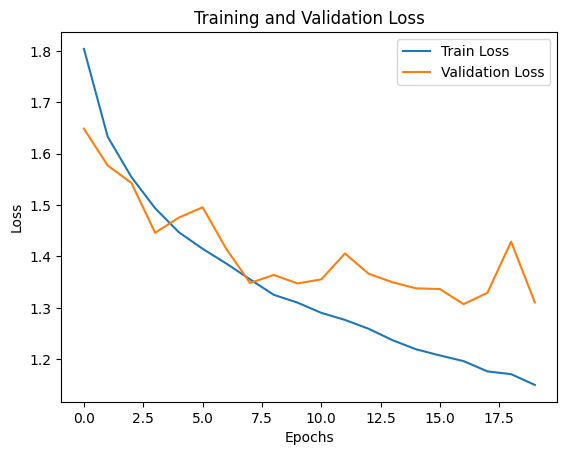

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.3042834507771575, 0.5422)

I think dropout stabilized training with batchnorm, loss don't jumps like he used to

### Without batchnorm

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p=0.3)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        self.selu = nn.SELU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.dropout(x)
        x = self.selu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.tanh(self.fc5(x))
        x = self.leaky_relu(self.fc6(x))
        x = self.selu(self.fc7(x))
        x = self.fc8(x)

        return x

net = Net()

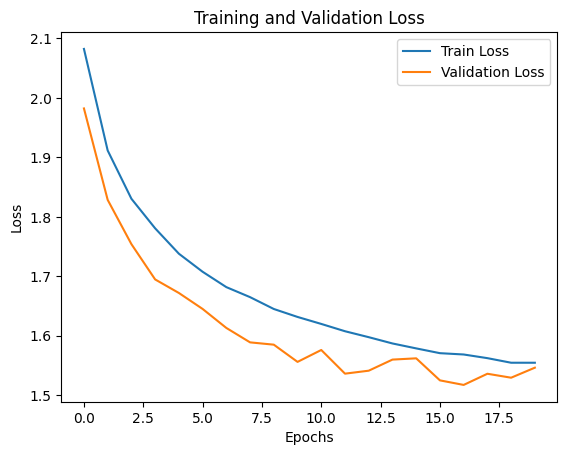

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.545579960171026, 0.4412)

1) How does the network performance change when adding Dropout?
When I added Dropout, my network became less prone to overfitting. However, training slowed down because the gradients became noisier. Overall, the model became more stable, but if Dropout is too strong, test accuracy may drop.

2) Is the model able to achieve better accuracy on validation/test data with Dropout?
In my case, yes. When I used only BatchNorm, the loss fluctuated a lot. But when I combined it with Dropout, training became more stable. However, using only Dropout without BatchNorm gave worse results.

3) Is it beneficial to use both Dropout and BatchNorm together?
Yes, combining them helps. BatchNorm normalizes activations and stabilizes training, while Dropout prevents overfitting. But placing Dropout right after BatchNorm might weaken the normalization effect, so layer placement matters.

4) Can you build a larger model with Dropout and avoid overfitting?
Yes, Dropout allows me to build larger models without severe overfitting. But if the p value is too high, training slows down or the model performs poorly.

5) What values of p are optimal?
I found that good values depend on the layer type:

Fully connected layers: p = 0.3 - 0.5
Convolutional layers: p = 0.1 - 0.3
In deep networks, Dropout can be lower near the output since early layers already filter information well. But all in all p=0.3 is one of the most
popular for FCN.

6) Does the optimal network architecture with BatchNorm differ from that without it?
Yes, without BatchNorm, I have to rely more on other regularization techniques, such as stronger Dropout or fewer neurons per layer. With BatchNorm, I can build deeper networks and even increase the learning rate a bit.

## Task 4. Having the best of it all. (35 points)

Finally, your task is to make experiments and build the best possible model for CIFAR classification and write a report on it. If you've made experiments in the tasks above, that's fine, you now only need to reflect on your experiments and create a report.

Hints on experimenting (some of them aare from Task 2):
- Start with no more than 2-3 hidden layers each having 5-7 neurons
- Think about how many neurons your input and output layers should have
- What activation function do you need to use in the last layer?
- Play with number of layers, numbers of neurons in layers, different activation functions
- Try different training **hyperparameters**: learning rate, number of epochs, type of optimizer, batch size, something else?
- Try different configurations of BatchNorm/Dropout
- Try different kinds of image preprocessing inside you Dataset class, e.g. resizing/normalising images, etc. Does optimal preprocesing differ when using Dropout/BatchNorm than that of for the network without Dropout/BatchNorm?

After you've done experimenting, document your experiments and describe your findings. Try to answer the following questions:
- What is maximum accuracy on test test that you were able to achieve? Do you think it is possible to get higher accuracy using fully-connected network? Why?
- Have you observed overfitting? When does it start, i.e. how big the network should be?
- How does the behaviour of the model change when you change different hyperparameters?
- What interesting behaviour have you observed? What was beneficial and what did not influence the model?

Here is also a hint on experimenting: try to change one parameter at time. When you change the parameter, retrain the network and see how the behaviour has changes. Log the results, so you can then a general picture of how each parameter influences the model training. This will also help you not to forget what you have already tried.

 There I'll use best net, that I found before - with dropout and batchnorm together, I will not be tuning the number of layers, neurons, or the overall architecture of the network, as I have already experimented with these aspects before. Instead, I will focus on other improvements such as optimization techniques, regularization methods (Dropout, BatchNorm), activation functions, and data augmentation strategies.

All, that will upgrade accuracy I'll use in future, all that not - not

### Softmax

I try to add softmax as the last layer activation func.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p=0.3)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        self.selu = nn.SELU()
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.selu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.tanh(self.fc5(x))
        x = self.leaky_relu(self.fc6(x))
        x = self.selu(self.fc7(x))
        x = self.fc8(x)

        x = self.softmax(x)

        return x

net = Net()

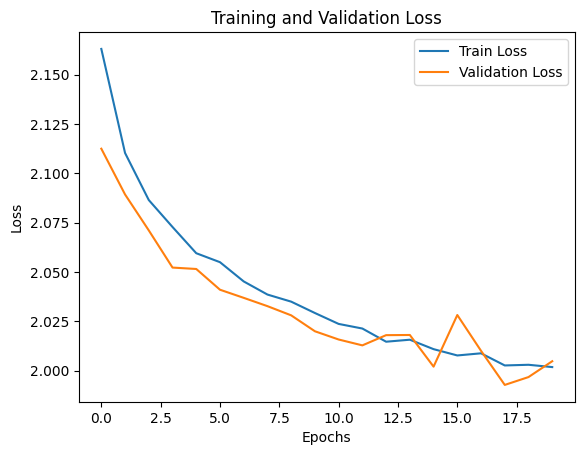

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(2.0026968370992155, 0.4537)

### Dropout p=0.4

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p=0.4)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        self.selu = nn.SELU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.selu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.tanh(self.fc5(x))
        x = self.leaky_relu(self.fc6(x))
        x = self.selu(self.fc7(x))
        x = self.fc8(x)

        return x

net = Net()

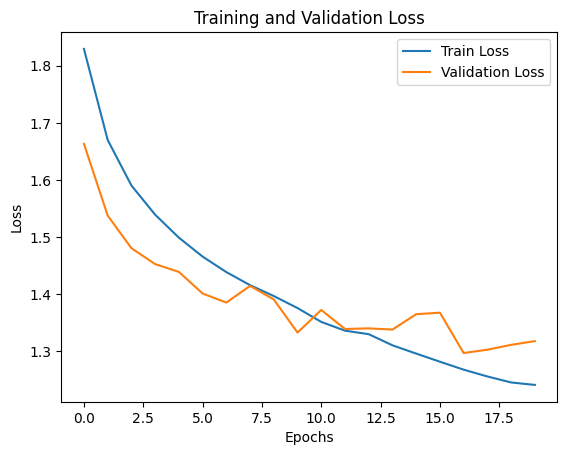

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.3109139345895748, 0.5406)

### Augmentations

In [ ]:
import torchvision.transforms as transforms

class CustomDataset_Aug(Dataset):
    def __init__(self, images_paths, transform=None):
        """
        Custom dataset with augmentations.
        images_paths — path to the folder with data
        transform — torchvision transforms for augmentation
        """
        self.images = []
        self.labels = []
        self.transform = transform

        for label_name in os.listdir(images_paths):
            label_path = os.path.join(images_paths, label_name)
            if os.path.isdir(label_path):
                label_idx = label_to_class[label_name]
                for img_name in os.listdir(label_path):
                    self.images.append(os.path.join(label_path, img_name))
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:

train_data_aug = CustomDataset_Aug('./cifar10/train', transform=train_transforms)
test_data_aug = CustomDataset_Aug('./cifar10/test', transform=test_transforms)
# we will allocate 80% of all images to the training sample
train_size_aug = int(len(train_data_aug) * 0.8)
# the remaining 20% will go to validation
val_size_aug = len(train_data_aug) - train_size_aug

# splitting the data
torch.manual_seed(42)
train_data_aug, val_data_aug = torch.utils.data.random_split(train_data_aug, [train_size_aug, val_size_aug])
batch_size = 32
train_loader_aug = torch.utils.data.DataLoader(train_data_aug, batch_size=batch_size, shuffle=True)
val_loader_aug = torch.utils.data.DataLoader(val_data_aug, batch_size=batch_size, shuffle=False)
test_loader_aug = torch.utils.data.DataLoader(test_data_aug, batch_size=batch_size, shuffle=False)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p=0.3)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        self.selu = nn.SELU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.selu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.tanh(self.fc5(x))
        x = self.leaky_relu(self.fc6(x))
        x = self.selu(self.fc7(x))
        x = self.fc8(x)

        return x

net = Net()

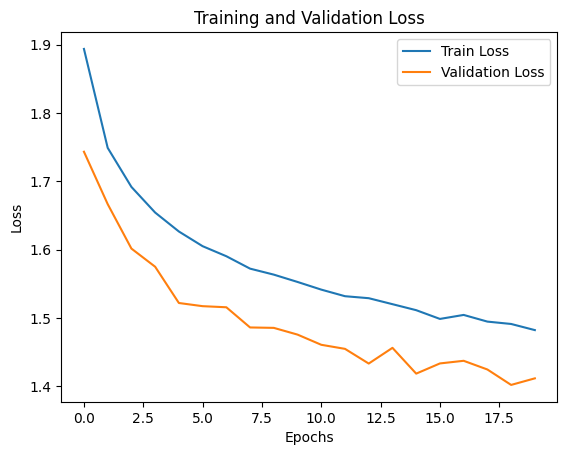

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader_aug, val_loader_aug, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader_aug, criterion)

(1.3224438466964819, 0.5365)

### Optimizer

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p=0.3)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        self.selu = nn.SELU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.selu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.tanh(self.fc5(x))
        x = self.leaky_relu(self.fc6(x))
        x = self.selu(self.fc7(x))
        x = self.fc8(x)

        return x

net = Net()

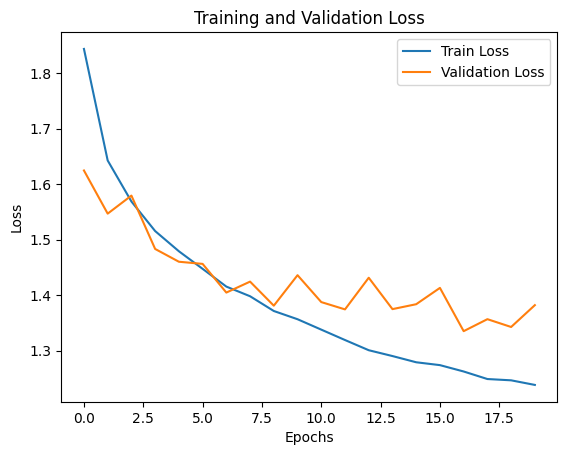

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.385880208053528, 0.5101)

### Scheduller

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(3 * 32 * 32, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 512)
        self.fc4 = nn.Linear(512, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 10)

        self.dropout = nn.Dropout(p=0.3)

        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.3)
        self.tanh = nn.Tanh()
        self.selu = nn.SELU()

    def forward(self, x):
        x = self.flatten(x)

        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.selu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.tanh(self.fc5(x))
        x = self.leaky_relu(self.fc6(x))
        x = self.selu(self.fc7(x))
        x = self.fc8(x)

        return x

net = Net()

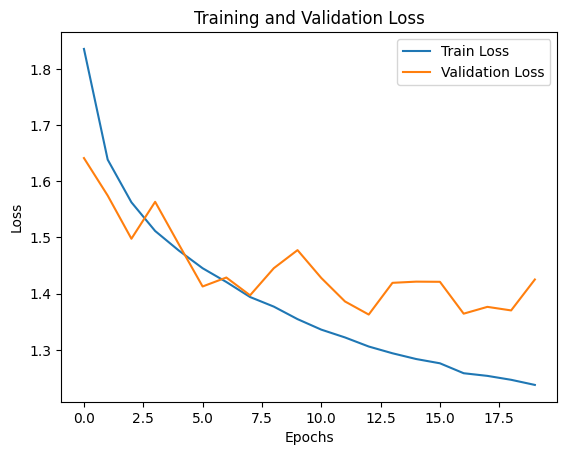

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# run training
num_epochs = 20
best_net, hist = train(net, train_loader, val_loader, criterion, optimizer, num_epochs)

In [ ]:
evaluate(best_net, test_loader, criterion)

(1.4355859899292358, 0.5031)

**Overall**

1) Maximum test accuracy achieved:
The best accuracy I was able to achieve was 0.5422. I believe it is unlikely to achieve higher accuracy using a fully connected network alone, as such networks are not well-suited for capturing complex spatial dependencies in images. To reach higher accuracy, convolutional networks should be considered, as they are specifically designed for image-related tasks.
Did I observe overfitting? When does it start, and how large should the network be?:

2) Overfitting typically started around the 8th-10th epoch. This happened when the network became too complex for the dataset. However, combining Dropout and BatchNorm yielded the best results: this approach helped reduce overfitting and improved the final score. If the network is too large or effective regularization techniques are not applied, overfitting appears relatively quickly.
How does the model’s behavior change with different hyperparameters?:

3) Changing hyperparameters like learning rate, number of epochs, batch size, and optimizer type had a significant impact on the results. For instance, using SGD resulted in lower accuracy (0.5101), while adding Dropout with p=0.4 showed only a small improvement compared to the original architecture. Adding augmentations also did not provide substantial improvement.
What interesting behaviors did I observe? What was beneficial, and what didn’t influence the model?:

4) Combining Dropout and BatchNorm together gave the best result, helping to reduce overfitting. However, using augmentations, such as random flips or brightness adjustments, did not provide a noticeable improvement compared to the original model. Too high values for hyperparameters like learning rate caused instability during training.